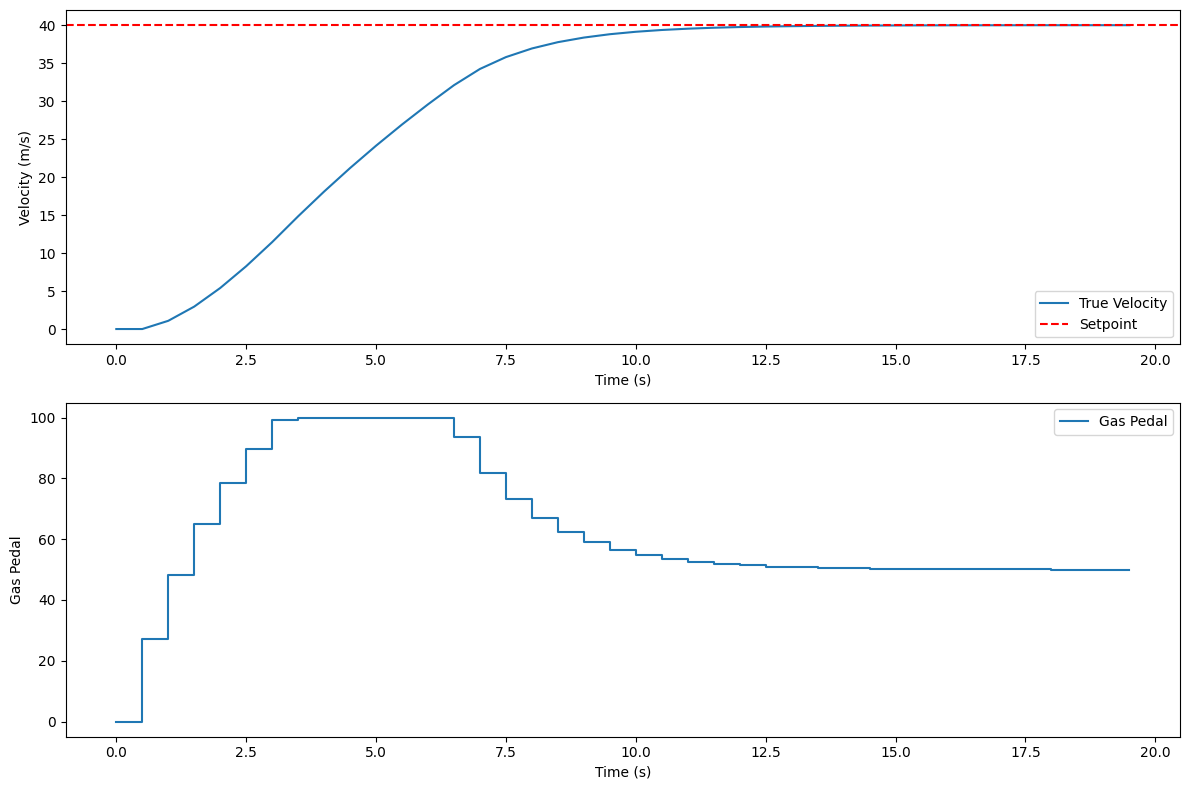

In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Constants
mass = 500  # Vehicle mass
b = 50  # Damping coefficient
K = 0.8  # Gain
SP = 40  # Setpoint velocity
dt = 0.5
time = np.arange(0, 20, dt)

# Parameters for smoothing and limiting gas pedal changes
DCOST = 0.1  # Penalize large changes in gas pedal movement

# Model to update velocity
def model(v_k, p_k):
    return v_k + (K * b * p_k - b * v_k) * dt / mass

# Cost function
def cost_function(p_sequence, v_initial, t):
    v_pred = v_initial
    J = 0.0
    SP_dynamic = np.clip(t / 5 * SP, 0, SP)  # Gradual ramp of setpoint
    for j in range(Np):
        p = p_sequence[min(j, Nc - 1)]
        v_pred = model(v_pred, p)
        if j > 0:
            J += (v_pred - SP_dynamic) ** 2 + DCOST * (p - p_sequence[j - 1]) ** 2
        else:
            J += (v_pred - SP_dynamic) ** 2
    return J

# MPC function
def mpc_control(v, t):
    p_initial = np.linspace(0, 50, Np)  # Gradual ramp for initial guess
    result = minimize(cost_function, p_initial, args=(v, t), bounds=[(0, 100)] * Np)
    return result.x[0] if result.success else 0.0

# Simulation setup
v = 0
Np = 20
Nc = 20
velocities = []
controls = []

for t in range(len(time)):
    p_opt = mpc_control(v, t * dt)
    velocities.append(v)
    controls.append(p_opt)
    v = model(v, p_opt)

# Crteate DataFrame with results
df = pd.DataFrame({'Time (s)': time, 'Velocity (m/s)': velocities, 'Gas Pedal': controls})

# Plotting
plt.figure(figsize=(12, 8))

# Velocity plot
plt.subplot(2, 1, 1)
plt.plot(time, velocities, label='True Velocity')
plt.axhline(y=SP, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

# Control action plot
plt.subplot(2, 1, 2)
plt.step(time, controls, where='post', label='Gas Pedal')
plt.xlabel('Time (s)')
plt.ylabel('Gas Pedal')
plt.legend()
plt.tight_layout()
plt.show()